# ДЗ 1

In [76]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy.optimize import minimize,minimize_scalar
from sklearn.linear_model import LinearRegression

# Вводная часть

Есть 4 товара. У всех у них закупочная цена = 900. Их функции представлены ниже. Первые 3 товара описаны функциями.

4-ый товар описывается правилами.

Если p<5000, то Q4=p/600, иначе 0.

+

Если сумма цен первого и четвертого товара меньше 1500, то его количество проданных Q4=Q4+Q1/7

+

Если сумма цен второго, третьего и четвертого товаров меньше 3000, то его Q4=Q4+Q2/10


<b>Важно!</b> Вы эти функции не знаете. Также вы не знаете о существовании зависимости для товара 4, полагая, что он точно также описывается каким-то параметрически законом. Также вы не знаете о правой границе (где спрос превращается в 0), полагая что она находится точно левее 5000. Для всех 4-ех товаров нужно выбрать параметрические функции (протестировать не менее 3-ех вариантов). И искать оптимум итерационно на все товары одновременно. Ваша цель: локальный оптимум по каждому товару, не глобальный.

На функции накладывается шум:
<ol>
<li>Усеченный нормальный </li> 
<li>Равномерный</li> 
</ol>
Стартовая точка

<code>
np.random.seed(Номер задания)
np.random.uniform(900 + len(ВАШЕ ФИО) + Номер задания*10, 1000 + Номер задания*10)
</code>

<b>Задание</b>

<ol>
<li>Нужно реализовать алгоритм поиска оптимума на 6-ой шаг. Можно использовать бины.</li> 
<li>Нужно реализовать наивный алгоритм оптимизации траектории. 
    <ul>
        <li>Тестировать на 6 шагах. Сравнить с результатом из предыдущего пункта.</li> 
        <li>Тестировать на 15 шагах.</li></ul>
    </li> 
<li>Нужно реализовать алгоритм оптимизации траектории.
    <ul>
        <li>Тестировать на 6 шагах для сравнения с другими алгоритмами.</li>
        <li>Тестировать на 15 шагах и сравнить с пунктом 2.</li>
    </ul>
</ol>
Сравнить разные параметрические модели между собой (по скорости нахождения, по точности). Провести анализ влияния дисперсии на скорость нахождения оптимальной цены.


In [4]:
p_ = 900

In [592]:
def my_trunc_norm(mu=1,sigma=0.02):
    return min(max(np.random.normal(mu, sigma),0.6),1.5)

def noise_decorator(func,):
    
    def wrapper(*args,noise=True):
        if noise:
            return func(*args)*my_trunc_norm()
        else:
            return func(*args)
    
    return wrapper

In [593]:
@noise_decorator
def Q1(p):
    if p<1000:
        return 0.5*np.exp(-p*0.001)
    elif p<1300:
        return 0.16
    elif p<1700:
        return 0.14
    elif p<2000:
        return 0.13
    elif p<2500:
        return -p*0.0001+0.33
    elif p<3000:
        return -p*0.00005+0.18
    else:
        return 0
    
def R1(p,c=900):
    return Q1(p)*(p-c)

In [594]:
@noise_decorator
def Q2(p):
    if p<2000:
        return (0.5*np.exp(-p*0.001)+p/10)/500
    elif p<3000:
        return (-p*0.001+100)/500
    else:
        return 0
    
def R2(p,c=900):
    return Q2(p)*(p-c)

In [595]:
@noise_decorator
def Q3(p):
    if p<8000:
        return 0.5*np.exp(-p*0.001)
    else:
        return 0
    
def R3(p,c=900):
    return Q3(p)*(p-c)

In [596]:
y1=[]
y2=[]
y3=[]

x = np.linspace(600, 3050, 500)
for i in x:
    y1.append(R1(i))
    y2.append(R2(i))
    y3.append(R3(i))


**Графики выручки для разных товаров в зависимости от цен**

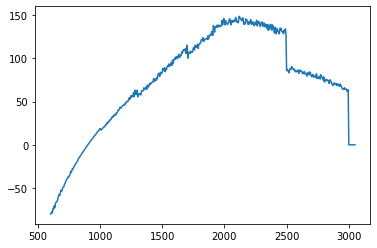

In [597]:
fig = plt.figure()
plt.plot(x, y1)

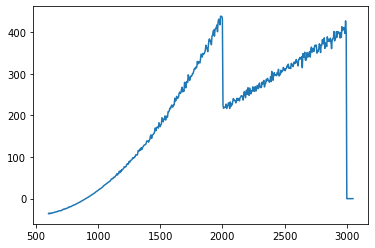

In [598]:
fig = plt.figure()
plt.plot(x, y2)

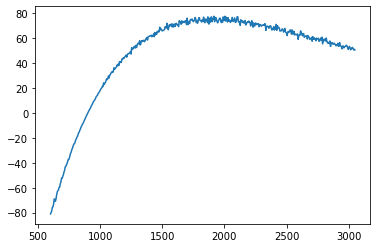

In [599]:
fig = plt.figure()
plt.plot(x, y3)

# Выбор параметрических функций

1. Линейная $Q(p) =  \max(ap + b, 0)$
2. Гиперболическая $Q(p) = \max(a/p + b, 0)$
3. Экспоненциальная $Q(p) = \max(aexp(-p) + d, 0)$

In [564]:
@noise_decorator
def Q4(p,p1,p2,p3):
    Q4 = 0
    if p<5000:
        Q4 = 600/p # !!!
        if p1+p < 1500:
            Q4+= Q1(p1)/7
        if p2+p3+p<3000:
            Q4+= Q4+Q2(p2)/10
    return Q4
    
def R4(p,Q4,c=900):
    """
    Поскольку функция спроса на четвертый товар зависит от других товаров, то на вход будем подавать вычисленную Q4, цену
    """
    return Q4*(p-c)

# Найдем оптимальные цены и соответствующие им прибыли

**Поскольку функции сроса первых трех товаров не зависят от других товаров, вычислим их независимо**

**Функция спроса четвертого товара зависит от первых трех, поэтому в качестве переменных, участвующих в вычислении функции будем использовать оптимальыне цены, посчитанные ранее**

In [1212]:
# p1,p2,p3

p1_b = 1000.0001
p2_b = 1000.0001
p3_b = 1000.0001

r1b = -np.inf
r2b = -np.inf
r3b = -np.inf
r4b = -np.inf


for p in np.linspace(10,5000,1000):
    
    if R1(p)>r1b:
        p1_b=p
        r1b=R1(p)
        
    if R2(p)>r2b:
        p2_b=p
        r2b=R2(p)
        
    if R3(p)>r3b:
        p3_b=p
        r3b=R3(p)
        
        
for p in np.linspace(10,5000,1000):
    
    r4_current = R4(p,Q4(p,p1_b,p2_b,p3_b))
    if r4_current>r4b:
        p4_b=p
        r4b=r4_current
    

# Алгоритм поиска оптимума


Алгоритм

0. устанавливаем множество допустимых цен
1. берем три точки, строим параболу
2. Сокращаем интервал допустимых точек в два раза, считая от максимума (opt_p - init_len/2, opt_p + init_len/2)
3. Извлекаем две точки по краям отрезка с шумом (left_edge + np.random.rand(1) * 100), (right_edge + np.random.rand(1) * 100)
4. Возвращаемся на 2 шаг и так  до истечения количества итераций.

In [1171]:
def main_func(X,y,p_opt,step,mode="linear"):

    """
    y - array of Revenue
    X - array of picked prices
    mode - function of approximation
    """
    
    # estimate opt_p
    # pick 2 points on the edge of new interval
    # add points and true revenues in sets
    # return p_opt, X,y,
    
    assert X.shape == y.shape == (len(X),)
    
    c = 900
    
    # предыдущий оптимум с отклонениями в меньшую и большую сторону - наша сетка поиска
    borders = (p_opt-ln_interval/step,p_opt+ln_interval/step)
    model = LinearRegression()
    y_train = y / (X-c)  # the same for all implementations
    
    # будем выбирать только 4 лучшие
    
    inds = np.argsort(y_train)[-3:]
    X = X[inds]
    
    y_train = y_train[inds]

    
    if mode=="linear": # вместо параболы будем обучать линейную функцию 
        X_train = X.copy()
        model.fit(X_train.reshape(-1,1), y_train)
        a= model.coef_[0]
        intercept = model.intercept_
        
        p_opt = minimize_scalar(lambda p: -(a*p+intercept)*(p-c),bounds=borders,method='bounded').x
        
        return p_opt, [a,intercept]
    
    
    if mode == "exponential":
        # Q(p) = ae^(-p) + b
        
        
        X_train = np.exp(-0.001*X.copy()).reshape(-1,1)
        X_train = np.concatenate((X_train,np.ones((len(X),1)) / X.reshape(-1,1) / np.log(X).reshape(-1,1)**10),axis=1)
        
        model.fit(X_train, y_train)
        a,b= model.coef_[0],model.coef_[1]
        
        p_opt = minimize_scalar(lambda p: -(a*np.exp(-0.001*p)+b / p / np.log(p)**10)*(p-c),bounds=borders,method='bounded').x
        
        return p_opt, [a,b]
    
    if mode == "hyperbole":
        
        X_train = 1 / X.copy().reshape(-1,1)
        X_train = np.concatenate((X_train, np.ones((len(X),1)) / np.log(X).reshape(-1,1)),axis=1)
        model.fit(X_train, y_train)
        
        a,b= model.coef_[0],model.coef_[1]
        
        p_opt = minimize_scalar(lambda p: -(a/p + b / np.log(p))*(p-c),bounds=borders,method='bounded').x
        
        return p_opt, [a,b]
        
        
        
        
        
        
    

In [1244]:
np.random.seed(2)
mode="exponential"
mode = "hyperbole"
# mode="linear"

init_interval = (1200,3200) 
ln_interval = 2000

X_dct = {f"X{i}":[] for i in range(1,5)}
y_dct = {f"y{i}":[] for i in range(1,5)}

# add two start points in sets of prices and revenues
for i in range(2):
    p_start = init_interval[i]
    
    for i in range(1,4):
        X_dct[f"X{i}"].append(p_start)
        y_dct[f"y{i}"].append(eval(f"R{i}(p_start)"))
        
    X_dct["X4"].append(p_start)
    y_dct["y4"].append(R4(p_start, Q4(p_start,p_start,p_start,p_start)))


opt_dct = {i:1500 for i in range(1,5)}
opt_save = {i:[1500,] for i in range(1,5)}
for step in np.linspace(4,6,3):
    p_left = [0,0,0]
    p_right = [0,0,0]
    for g in range(1,4):
        p_opt, params = main_func(np.array(X_dct[f"X{g}"]),np.array(y_dct[f"y{g}"]),opt_dct[g],step,mode=mode)
        opt_dct[g] = p_opt
        opt_save[g].append(p_opt)
        
    
        
        x_left,x_right = (p_opt-ln_interval/step/2 + (np.random.rand(1) * 300/step)[0],p_opt+ln_interval/step/2 - (np.random.rand(1) *200/step)[0])
        
        #save x for 4 estimation
        
        p_left[g-1] = x_left
        p_right[g-1] = x_right
        
        X_dct[f"X{g}"].append(x_left)
        X_dct[f"X{g}"].append(x_right)
        
        y_dct[f"y{g}"].append(eval(f"R{g}({x_left})"))
        y_dct[f"y{g}"].append(eval(f"R{g}({x_right})"))
        
        
    # for forth good
    
    g = 4
    
    
    p_opt, params = main_func(np.array(X_dct[f"X{g}"]),np.array(y_dct[f"y{g}"]),opt_dct[g],step,mode=mode)
    opt_dct[g] = p_opt
    opt_save[g].append(p_opt)



    x_left,x_right = (p_opt-ln_interval/step/2 + (np.random.rand(1) * 100/step)[0], p_opt+ln_interval/step/2 - (np.random.rand(1) *100/step)[0])

    X_dct[f"X{g}"].append(x_left)
    X_dct[f"X{g}"].append(x_right)
    
    

    y_dct[f"y{g}"].append(eval(f"R{g}({x_left}, {Q4(x_left,*p_left)})"))
    y_dct[f"y{g}"].append(eval(f"R{g}({x_right},{Q4(x_right, *p_right)})"))
    
    
    
    
    
    

In [1242]:
def plot_results(g,mode="linear"):
    plt.figure(figsize=(7,5))
    c=900
    
    
    
    X=np.array(X_dct[f"X{g}"])
    y=np.array(y_dct[f"y{g}"])
    
    X_init = X.copy()
    y_init = y.copy()
    
    inds = np.argsort(y)[-4:]
    y_train = y / (X-c) 
    X = X[inds]
    y_train = y_train[inds]
    y = y[inds]
    borders=(1000,5000)
    linear = LinearRegression(fit_intercept=False)
    
    if mode=="linear":
        X_train = np.concatenate((X.copy().reshape(-1,1),np.ones((len(X),1))),axis=1)
        
    elif mode=="exponential": # домножим на 0.001
        X_train = np.exp(-0.001*X.copy()).reshape(-1,1)
        X_train = np.concatenate((X_train,np.ones((len(X),1)) / X.reshape(-1,1) / np.log(X).reshape(-1,1)**10),axis=1)
    elif mode=="hyperbole":
        X_train = 1 / X.copy().reshape(-1,1)
        X_train = np.concatenate((X_train, np.ones((len(X),1))),axis=1)
    linear.fit(X_train, y_train)
    a,b = linear.coef_

    true = []
    pred=[]
    p_lst = np.linspace(800,3500,500)
    
    for p in np.linspace(800,3500,500):
        if mode=="linear":
            pred.append((linear.coef_[0]*p + linear.coef_[1])*(p-900))
            p_opt = minimize_scalar(lambda p: -(a*p+b)*(p-c),bounds=borders,method='bounded').x
        elif mode=="exponential":
            pred.append((linear.coef_[0]*np.exp(-0.001*p) + linear.coef_[1] / p / np.log(p)**10)*(p-900))
            p_opt = minimize_scalar(lambda p: -(a*np.exp(-0.001*p)+b / p / np.log(p)**10)*(p-c),bounds=borders,method='bounded').x
        elif mode=="hyperbole":
            pred.append((linear.coef_[0] / p + linear.coef_[1])*(p-900))
            p_opt = minimize_scalar(lambda p: -(a/p + b / np.log(p))*(p-c),bounds=borders,method='bounded').x
        true.append(eval(f"R{g}(p)"))
    plt.plot(p_lst,true)    
    plt.plot(p_lst,pred)   
    plt.scatter(X_init,y_init,color="red",)
    plt.scatter(opt_save[g], eval(f"[R{g}(k) for k in opt_save[{g}]]"),color="black",label="chosen optimal")
    l_opt = p_opt
    
    r_pred = eval(f"R{g}({l_opt})+1")
    r_best = eval(f"r{g}b")
    if True:
        ind = np.argmax(y_init)
        r_pred = y_init[ind]
        l_opt = X_init[ind]
        
    plt.scatter(l_opt, eval(f"R{g}({l_opt})+1"),color="green",label="last optimal",s=200,marker="+")    
    plt.title("ошибка "+str(abs(round((r_best-r_pred)/r_best,3))))
    

# N steps plots

# LINEAR

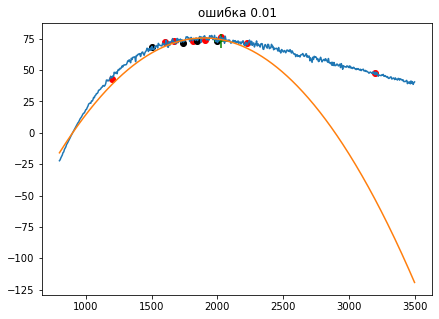

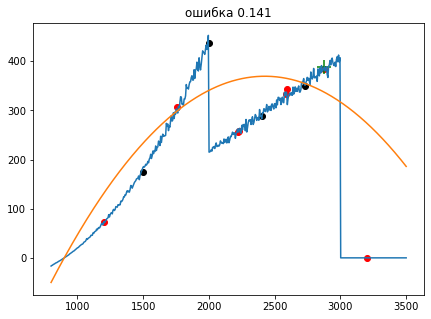

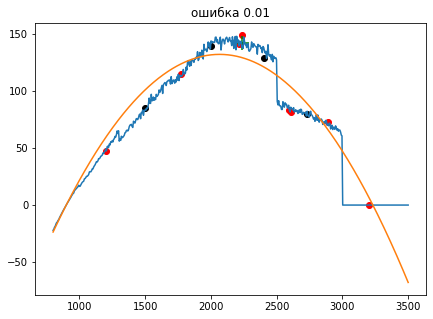

In [1236]:
plot_results(3,mode=mode)
plot_results(2,mode=mode)
plot_results(1,mode=mode)

# Exponential

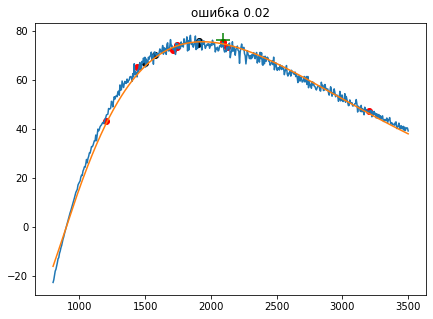

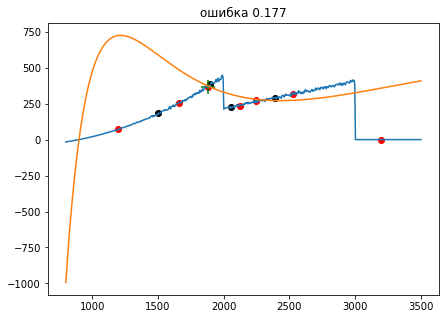

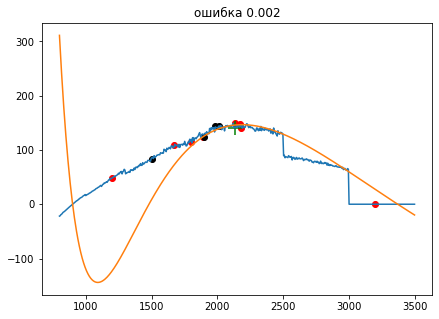

In [1243]:
plot_results(3,mode=mode)
plot_results(2,mode=mode)
plot_results(1,mode=mode)

# Hyperbole

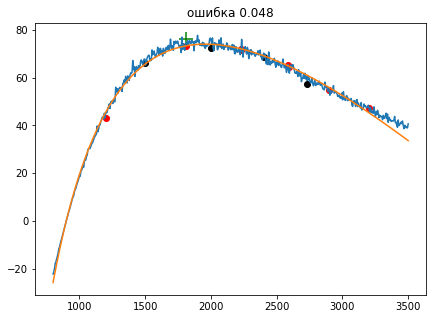

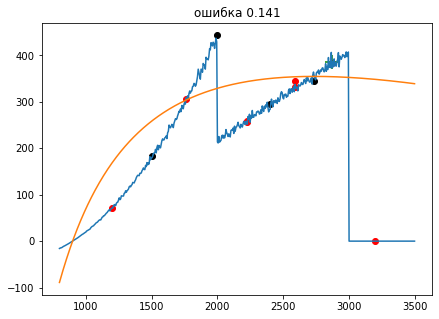

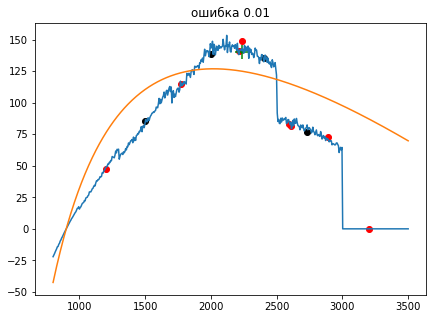

In [1245]:
plot_results(3,mode=mode)
plot_results(2,mode=mode)
plot_results(1,mode=mode)

In [ ]:
def plot_results(g,mode="linear"):
    plt.figure(figsize=(7,5))
    c=900
    
    X=np.array(X_dct[f"X{g}"])
    y=np.array(y_dct[f"y{g}"])
    y_train = y / (X-c) 

    linear = LinearRegression(fit_intercept=False)
    if mode=="linear":

        X_train = np.concatenate((X.copy().reshape(-1,1),np.ones((len(X),1))),axis=1)
    elif mode=="exponential": # домножим на 0.001
        X_train = np.exp(-0.001*X.copy()).reshape(-1,1)
        X_train = np.concatenate((X_train,np.ones((len(X),1)) / np.log(X).reshape(-1,1)**3),axis=1)
        
    linear.fit(X_train, y_train)

    print(linear.coef_)

    true = []
    pred=[]
    p_lst = np.linspace(800,5000,1000)
    
    for p in np.linspace(800,5000,1000):
        if mode=="linear":
            pred.append((linear.coef_[0]*p + linear.coef_[1])*(p-900))
        elif mode=="exponential":
            pred.append((linear.coef_[0]*np.exp(-0.001*p) + linear.coef_[1] / np.log(p)**3)*(p-900))
        true.append(eval(f"R{g}(p)"))
    plt.plot(p_lst,true)    
    plt.plot(p_lst,pred)   
    plt.scatter(X,y,color="red",)
    plt.scatter(opt_save[g], eval(f"[R{g}(k) for k in opt_save[{g}]]"),color="black")

# Наивный алгоритм оптимизации траектории

**Идеология**


1. Инициализируем начальную цену. 
2. Инициализируем вторую цену (начальная цена + 2000)

В цикле
1. Находим оптимальные параметры для функции прибыли
2. Выбираем следующую оптимальную цену. 



In [1246]:
class UpdateLinear:
    def __init__(self,):
        self.name = "UpdateLinear"
        
    def update(self,X_array, y_array,mode="quadratic",flag=False):
        """
        Модель - квадратичная функция. 
        Возвращает текущую оптимальную цену
        
        Минимизируем ошибку между функцией прибыли
        
        """
        c = 900
        linear = LinearRegression()
        if mode=="quadratic":
        

            arr1 = X_array.copy().reshape(-1,1)
            arr2 = (arr1**2)
            X_train = np.concatenate((arr2,arr1),axis=1)

            linear.fit(X_train, y_array)

            if (linear.coef_[0]==0) or (linear.coef_[1]==0): # Нужно на первых итерациях
                return float(2000 + 1000*np.random.rand(1)),0,0,0

            p_opt = -linear.coef_[1] / linear.coef_[0]/2

            if p_opt<0: # такое возможно
                return float(300 + 2000*np.random.rand(1)), linear.coef_[1], linear.coef_[0], linear.intercept_

            if flag and p_opt>2999: # знаю, что граница точно ниже 3000 
                return float(2000 + 1000*np.random.rand(1)), linear.coef_[1], linear.coef_[0], linear.intercept_
            
            return p_opt, linear.coef_[1], linear.coef_[0], linear.intercept_
        

        if mode=="exponential":
            # Q(p) = ae^(-p) + b
            # R(p) = ape^(-p) + pb - ace^(-p) - cb
            p = X_array.copy().reshape(-1,1)
            
            X_train = np.concatenate((p*np.exp(-0.001*p)-c*np.exp(-0.001*p), p-c),axis=1)
            
            linear.fit(X_train, y_array)

            if (linear.coef_[0]==0) and (linear.coef_[1]==0): # Нужно на первых итерациях
                return float(1500 + 1000*np.random.rand(1)),0,0,0
            
            
            a = linear.coef_[0]
            b = linear.coef_[1]
            intercept = linear.intercept_

            
            
            
            p_opt = minimize_scalar(lambda p: -(a*(p*np.exp(-0.001*p)-c*np.exp(-0.001*p))+b*(p-c)),bounds=(200,4000),method='bounded').x

            if p_opt<0: # такое возможно
                return float(300 + 2000*np.random.rand(1)),a,b,intercept

            if flag and p_opt>2999: # знаю, что граница точно ниже 3000 
                return float(2000 + 1000*np.random.rand(1)),a,b,intercept
            
            return p_opt, a,b,intercept
        
        
        if mode=="hyperbole":
            # Q(p) = a / p + b
            # R(p) = a(1-c/p) + b(p-c)
            
            p = X_array.copy().reshape(-1,1)
            
            X_train = np.concatenate(((1-c/p),p-c),axis=1)
            
            linear.fit(X_train, y_array)
            
            
            if (linear.coef_[0]==0) and (linear.coef_[1]==0): # Нужно на первых итерациях
                return float(1500 + 1000*np.random.rand(1)),0,0,0
            
            
            a = linear.coef_[0]
            b = linear.coef_[1]
            intercept = linear.intercept_

            
            
            
            p_opt = minimize_scalar(lambda p: -(a*(1-c/p)+b*(p-c)),bounds=(200,4000),method='bounded').x

            if p_opt<0: # такое возможно
                return float(300 + 2000*np.random.rand(1)),a,b,intercept

            if flag and p_opt>2999: # знаю, что граница точно ниже 3000 
                return float(2000 + 1000*np.random.rand(1)),a,b,intercept
            
            
            return p_opt, a,b,intercept
            
    
    
            

In [1287]:
mode = "quadratic"
# mode = "hyperbole"
# mode="exponential"

np.random.seed(2)
n_task = 2
p_start = np.random.uniform(900 + len("Михаил") + n_task*10, 1000 + n_task*10)

X1 = [p_start,]
X2 = [p_start,]
X3 = [p_start,]
X4 = [p_start,]

y1 = [R1(p_start),]
y2 = [R2(p_start),]
y3 = [R3(p_start),]
y4 = [R4(p_start, Q4(p_start,p_start,p_start,p_start))]

upd = UpdateLinear()

for n in range(20):
    
    p1,a1,b1,int1 = upd.update(np.array(X1),np.array(y1),mode=mode)
    X1.append(p1)
    y1.append(R1(p1))
    
    
    
    p2,a2,b2,int2 = upd.update(np.array(X2),np.array(y2),mode=mode)
    X2.append(p2)
    y2.append(R2(p2))
    
    p3,a3,b3,int3= upd.update(np.array(X3),np.array(y3),mode=mode)
    X3.append(p3)
    y3.append(R3(p3))
    
    
    p4,a4,b4,int4 = upd.update(np.array(X4),np.array(y4),mode=mode,flag=True)
    X4.append(p4)
    y4.append(R4(p4, Q4(p4,p1,p2,p3)))
    
    
    
    
    
    

In [1288]:
def plot_linear(X1,y1,R1,a,b, intercept,mode='quadratic'):
    c=900
    
    axisx = []
    axisy = []
    pred=[]

    
    for x in np.linspace(800,4000,500):
        axisx.append(x)
        axisy.append(R1(x))
        if mode=="quadratic":
            pred.append(x*x*b+x*a+intercept)
            
        if mode=="exponential":
            p=x
            pred.append(a*(p*np.exp(-0.001*p)-c*np.exp(-0.001*p))+b*(p-c))
            
        if mode=="hyperbole":
            p=x
            pred.append(a*(1-c/p)+b*(p-c))
    plt.plot(axisx,axisy)
    plt.plot(axisx,pred)
    
    ind = np.argmax(pred)
    r_opt = axisy[ind]
    p_opt =  np.linspace(800,4000,500)[ind]

    plt.scatter(p_opt,r_opt,label="p_opt",color="r",s=100)
    plt.legend()
    return r_opt

# linear

Text(0.5, 1.0, 'quadratic 0.031')

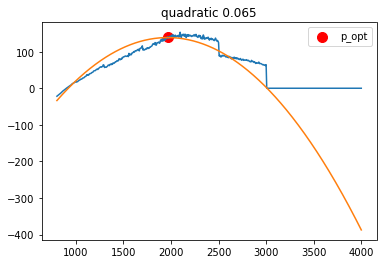

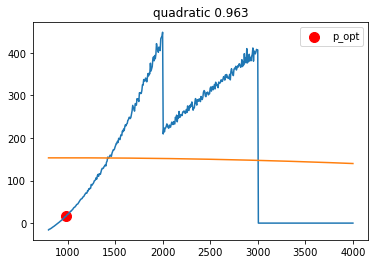

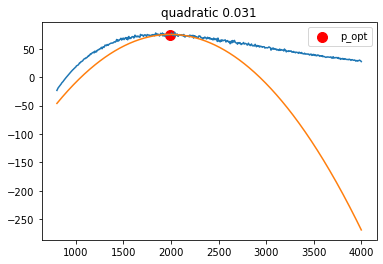

In [1289]:
mode = "quadratic"
r1opt=plot_linear(X1,y1,R1,a1,b1,int1,mode=mode)
plt.title(f"{mode} "+str(round(abs((r1b-r1opt)/r1b),3)))
plt.figure(figsize=(6,4))

r2opt=plot_linear(X2,y2,R2,a2,b2,int2,mode=mode)
plt.title(f"{mode} "+str(round(abs((r2b-r2opt)/r2b),3)))
plt.figure(figsize=(6,4))

r3opt=plot_linear(X3,y3,R3,a3,b3,int3,mode=mode)
plt.title(f"{mode} "+str(round(abs((r3b-r3opt)/r3b),3)))

# exponential

Text(0.5, 1.0, 'exponential 0.002')

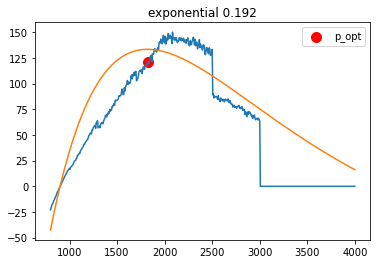

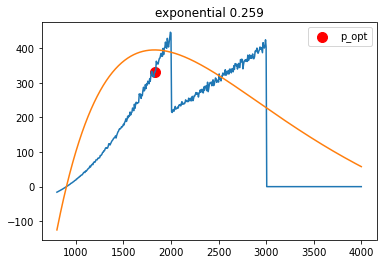

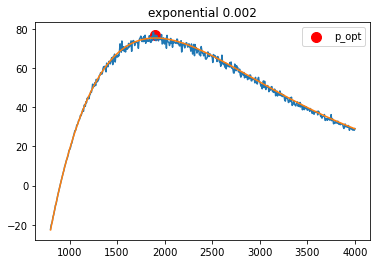

In [1282]:
mode='exponential'
r1opt=plot_linear(X1,y1,R1,a1,b1,int1,mode=mode)
plt.title(f"{mode} "+str(round(abs((r1b-r1opt)/r1b),3)))
plt.figure(figsize=(6,4))

r2opt=plot_linear(X2,y2,R2,a2,b2,int2,mode=mode)
plt.title(f"{mode} "+str(round(abs((r2b-r2opt)/r2b),3)))
plt.figure(figsize=(6,4))

r3opt=plot_linear(X3,y3,R3,a3,b3,int3,mode=mode)
plt.title(f"{mode} "+str(round(abs((r3b-r3opt)/r3b),3)))

# Hyperbole

Text(0.5, 1.0, 'hyperbole 0.041')

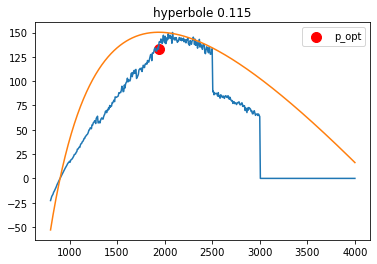

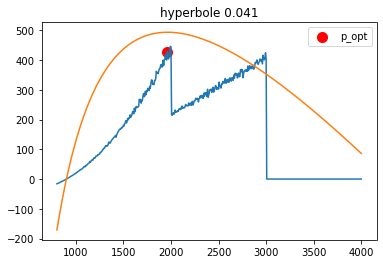

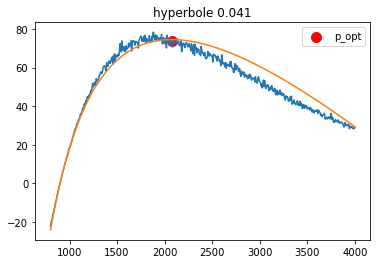

In [1279]:
mode="hyperbole"
r1opt=plot_linear(X1,y1,R1,a1,b1,int1,mode=mode)
plt.title(f"{mode} "+str(round(abs((r1b-r1opt)/r1b),3)))
plt.figure(figsize=(6,4))

r2opt=plot_linear(X2,y2,R2,a2,b2,int2,mode=mode)
plt.title(f"{mode} "+str(round(abs((r2b-r2opt)/r2b),3)))
plt.figure(figsize=(6,4))

r3opt=plot_linear(X3,y3,R3,a3,b3,int3,mode=mode)
plt.title(f"{mode} "+str(round(abs((r3b-r3opt)/r3b),3)))

# 4 Good

In [1291]:
from sklearn.linear_model import Ridge

Error 0.26559533209775704


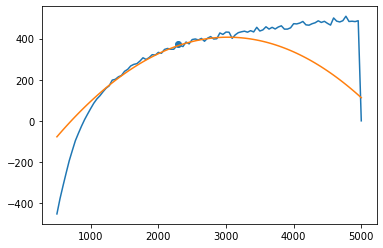

In [1300]:
# зафиксируем оптимальыне цены для предыдущих товаров и построим график для 4-ого товара
p1=X1[-1]
p2=X2[-1]
p3=X3[-1]
q1=Q1(p1)
q2=Q1(p2)
q3=Q1(p3)

arr1=np.array(X4).reshape(-1,1)
arr2 = arr1**2
x_train=np.concatenate((arr1,arr2),axis=1)

linear=Ridge()
linear.fit(x_train,y4)


axisx = []
axisy = []
pred=[]
a,b=linear.coef_[1],linear.coef_[0]
c=linear.intercept_
for x in np.linspace(500,5000,100):
    axisx.append(x)
    axisy.append(R4(x,Q4(x,p1,p2,p3)))
    pred.append(x*x*a+x*b+c)
plt.plot(axisx,axisy)
plt.plot(axisx,pred)

x = X4[-1]
r4opt = R4(x,Q4(x,p1,p2,p3))
plt.scatter(x,r4opt)
print("Error",(r4b-r4opt)/r4b)

# Оптимизация траектории. Помимо исследования функции в качестве пробных цен добавляем оптимум на каждой третьей итерации

In [1315]:
np.random.seed(2)
mode="exponential"
# mode = "hyperbole"
# mode="linear"

init_interval = (1200,3200) 
ln_interval = 2000

X_dct = {f"X{i}":[] for i in range(1,5)}
y_dct = {f"y{i}":[] for i in range(1,5)}

# add two start points in sets of prices and revenues
for i in range(2):
    p_start = init_interval[i]
    
    for i in range(1,4):
        X_dct[f"X{i}"].append(p_start)
        y_dct[f"y{i}"].append(eval(f"R{i}(p_start)"))
        
    X_dct["X4"].append(p_start)
    y_dct["y4"].append(R4(p_start, Q4(p_start,p_start,p_start,p_start)))


opt_dct = {i:1500 for i in range(1,5)}
opt_save = {i:[1500,] for i in range(1,5)}
for step in np.linspace(4,6,3):
    p_left = [0,0,0]
    p_right = [0,0,0]
    for g in range(1,4):
        p_opt, params = main_func(np.array(X_dct[f"X{g}"]),np.array(y_dct[f"y{g}"]),opt_dct[g],step,mode=mode)
        opt_dct[g] = p_opt
        opt_save[g].append(p_opt)
        
    
        
        x_left,x_right = (p_opt-ln_interval/step/2 + (np.random.rand(1) * 300/step)[0],p_opt+ln_interval/step/2 - (np.random.rand(1) *200/step)[0])
        
        #save x for 4 estimation
        
        p_left[g-1] = x_left
        p_right[g-1] = x_right
        
        X_dct[f"X{g}"].append(x_left)
        X_dct[f"X{g}"].append(x_right)
        X_dct[f"X{g}"].append(p_opt)
        
        y_dct[f"y{g}"].append(eval(f"R{g}({x_left})"))
        y_dct[f"y{g}"].append(eval(f"R{g}({x_right})"))
        y_dct[f"y{g}"].append(eval(f"R{g}({p_opt})"))
        
        
    # for forth good
    
    g = 4
    
    
    p_opt, params = main_func(np.array(X_dct[f"X{g}"]),np.array(y_dct[f"y{g}"]),opt_dct[g],step,mode=mode)
    opt_dct[g] = p_opt
    opt_save[g].append(p_opt)



    x_left,x_right = (p_opt-ln_interval/step/2 + (np.random.rand(1) * 100/step)[0], p_opt+ln_interval/step/2 - (np.random.rand(1) *100/step)[0])

    X_dct[f"X{g}"].append(x_left)
    X_dct[f"X{g}"].append(x_right)
#     X_dct[f"X{g}"].append(p_opt)
    

    y_dct[f"y{g}"].append(eval(f"R{g}({x_left}, {Q4(x_left,*p_left)})"))
    y_dct[f"y{g}"].append(eval(f"R{g}({x_right},{Q4(x_right, *p_right)})"))
#     y_dct[f"y{g}"].append(eval(f"R{g}({p_opt},{Q4(p_opt, *p_right)})"))
    
    
    
    
    

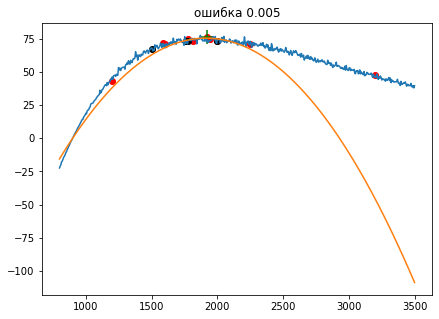

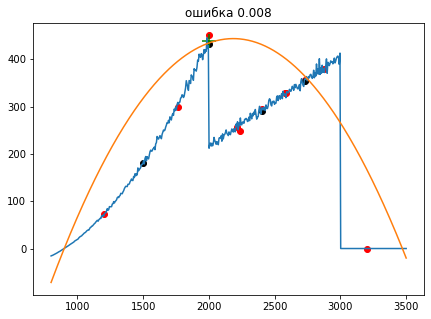

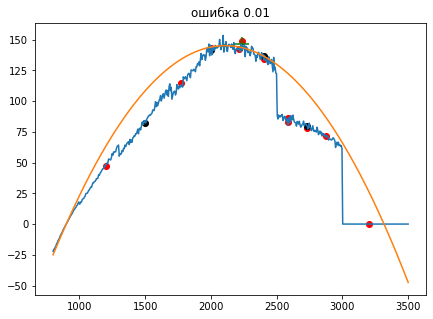

In [1312]:
plot_results(3,mode=mode)
plot_results(2,mode=mode)
plot_results(1,mode=mode)

# Exponential

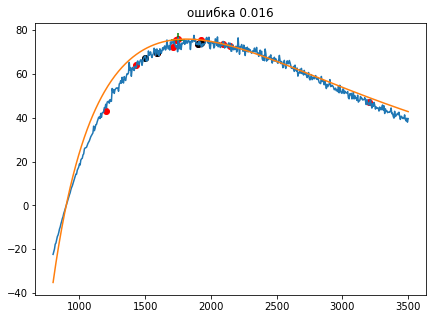

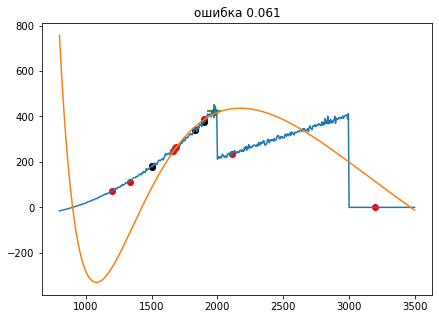

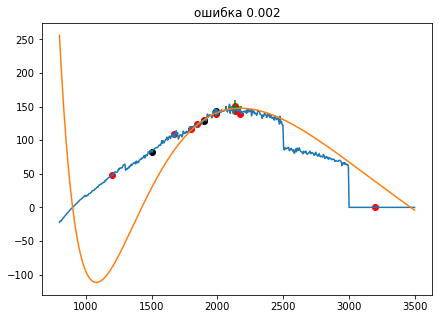

In [1316]:
plot_results(3,mode=mode)
plot_results(2,mode=mode)
plot_results(1,mode=mode)

# Hyperbole

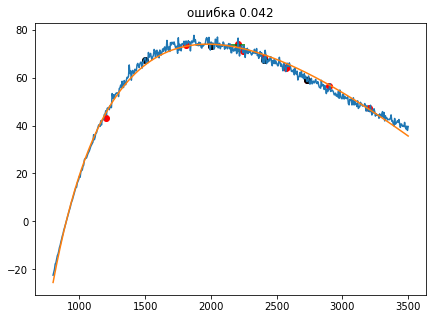

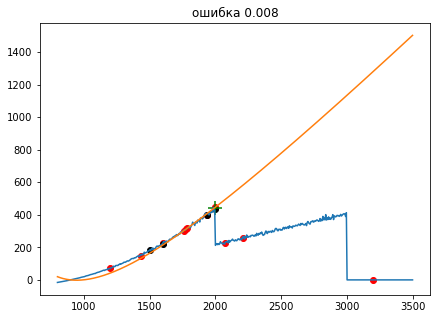

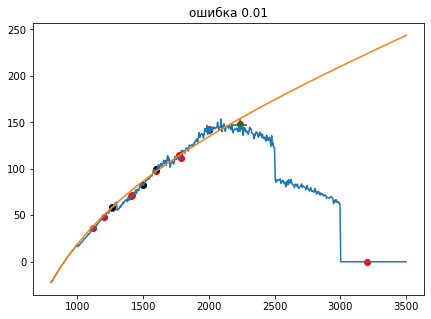

In [1314]:
plot_results(3,mode=mode)
plot_results(2,mode=mode)
plot_results(1,mode=mode)

# Выводы

**Все три алгоритма хорошо подходят для поиска оптимальной цены**. 

**Лучшей функцией для аппроксимации является парабола, так как лучше всего восстанавливает спрос на товар**



**Влияние дисперсии на поиск оптимальной цены**

Чем выше шум, тем меньшая точность оценивания. 

Заметил, что если оптимизироваться по трем-четырем лучшим точкам, то от шума качество сильно проседает. В качестве решения можно использовать большее количество точек